**Dirichlet Variational Autoencoder (DVAE)**
---
**Imports**

---

External libraries required for operation

In [1]:
import json
import h5py
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import sklearn.metrics as sk

2025-07-22 08:47:24.773977: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 08:47:24.784131: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 08:47:24.799530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753199244.824318 2917357 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753199244.831900 2917357 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753199244.866689 2917357 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Opening the trainer_config.json file:

In [2]:
TRAINER_CONFIG_FILE_LOCATION = 'config/trainer_config.json'
model_type = 'AE'
with open(TRAINER_CONFIG_FILE_LOCATION, 'r') as file:
    train_config = json.load(file)

**Data Preprocessing**

---

This block will open and validate the background data file. It must contain the directory "Particles" within it in order for us to continue. It will then save it into a numpy array to be used for model training.

In [3]:
#Opening file in read mode...
data_file = h5py.File(train_config["data_files"]["background_file"], 'r')



#Checking for validity...
is_file_valid = False
required_dataset = train_config["datasets"]["required_dataset"]
for key in data_file['/']:
    if isinstance(data_file['/' + key], h5py.Dataset) and key == required_dataset:
        is_file_valid = True



#Stop if file is not valid...
if not is_file_valid:
    raise Exception("File Does not contain the required dataset")



#Save it into a numpy array...
preprocessed_data = np.array(data_file[required_dataset])

**Data Splitting**

---

Splitting data into testing, validating and training sets. So that the model is tested and validated with unique data that it was not trained on (prevents overfitting!)

In [4]:

# TODO label
for i, batch in enumerate(preprocessed_data):
    pt_sum = 0
    for j, particle in enumerate(preprocessed_data[i, :, :]):
        if particle[3] != 0:
            pt_sum += particle[0]
    for j, particle in enumerate(preprocessed_data[i, :, :]):
        particle[0] = particle[0] / pt_sum



#Save data_train, data_validate, and data_test (if needed)...
data_train = preprocessed_data[train_config["data_split"]["train_split_start"]:train_config["data_split"]["train_split_end"], :, 0:3].reshape(-1, 57)
data_validate = preprocessed_data[train_config["data_split"]["val_split_start"]:train_config["data_split"]["val_split_end"], :, 0:3].reshape(-1, 57)

### MAY BE COMMENTED OUT IF TEST DATA IS NOT NEEDED!
data_test = preprocessed_data[train_config["data_split"]["test_split_start"]:train_config["data_split"]["test_split_end"], :,0:3].reshape(-1, 57)
###



# Truncate data if there is a max...
if train_config["data_split"]["max_data"] != "None":
    data_test = data_test[:train_config["data_split"]["max_data"]]
    print("Generated The Following Datasets\n Train Data Shape : {}\n Validation Data Shape : {}\n Test Data Shape : {}".format(data_train.shape, data_validate.shape,data_test.shape))
else:
    print("Generated The Following Datasets\n Train Data Shape : {}\n Validation Data Shape : {}\n Test Data Shape : {}".format(data_train.shape, data_validate.shape,data_test.shape))

Generated The Following Datasets
 Train Data Shape : (2000000, 57)
 Validation Data Shape : (399999, 57)
 Test Data Shape : (70000, 57)


**Model Initialization**

---

The Autoencoder Model class:

In [5]:
class EDLModel(Model):
    """
    This model replaces the VAE parameters with the Dirichlet Paramaters

    """
    def __init__(self, train_config):
        super(EDLModel, self).__init__()
        self.input_shape = (train_config["encoder_design"]["input_layer_dimension"],)
        self.latent_dim = 2 # This is fixed since we have just two classes
        self.train_config = train_config

        # Encoder
        self.encoder_input = layers.Input(shape=self.input_shape)
        dimensions = train_config["encoder_design"]["inner_layer_dimensions"]
        x = self.encoder_input
        for dim in dimensions:
            self.encoder_x = layers.Dense(dim, activation='relu')(x)
            x = self.encoder_x
        self.alpha = layers.Dense(self.latent_dim, activation='softplus')(self.encoder_x)
        self.z = Sampling()(self.alpha)

        # Decoder
        self.decoder_input = layers.Input(shape=(self.latent_dim,))
        op_layer_dimension_list = train_config["decoder_design"]["inner_layer_dimensions"]
        x = self.decoder_input
        for dim in op_layer_dimension_list:
            self.decoder_x = layers.Dense(dim, activation='relu')(x)
            x = self.decoder_x
        self.decoder_output = layers.Dense(self.input_shape[0], activation='relu')(self.decoder_x)

        self.encoder = Model(self.encoder_input, [self.z, self.alpha])
        self.decoder = Model(self.decoder_input, self.decoder_output)

        self.num_classes = train_config["encoder_design"]["latent_layer_dimension"]
        self.prior_alpha = tf.constant([1.0] * self.num_classes, dtype=tf.float32)

    def call(self, inputs):
        alpha, z = self.encoder(inputs)
        prior_alpha = tf.broadcast_to(self.prior_alpha, tf.shape(alpha))
        kl_loss = tf.reduce_sum(tfp.distributions.Dirichlet(alpha).kl_divergence(tfp.distributions.Dirichlet(prior_alpha))) #TODO debug 
        strength = self.train_config["hyperparameters"]["kl_strength"]
        reconstructed = self.decoder(z)
        mse = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = mse(inputs, reconstructed) * self.input_shape[0]

        total_loss = reconstruction_loss + strength * kl_loss
        self.add_loss(total_loss)
        return reconstructed


class Sampling(layers.Layer):
    """Uses the alpha dirichlet to sample"""

    def call(self, inputs):
        return tfp.distributions.Dirichlet(inputs).sample()



Initialize an instance of the above class

In [6]:
model = EDLModel(train_config)

2025-07-22 08:49:08.233877: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


**Model Training**

---

In [7]:
early_stopping = EarlyStopping(patience=train_config["hyperparameters"]["stop_patience"], restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=train_config["hyperparameters"]["lr_patience"], verbose=1)

print("compiling EDL")
model.compile(optimizer=Adam())
x_train = data_train
y_train = data_train
x_val = data_validate
y_val = data_validate
history = model.fit(
            x=x_train,
            y=y_train,
            validation_data=(x_val, y_val),
            epochs=train_config["hyperparameters"]["epochs"],
            batch_size=train_config["hyperparameters"]["batch_size"],
            callbacks=[early_stopping, reduce_lr]
            )

compiling EDL
Epoch 1/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 97405.2578 - val_loss: 2017.7299 - learning_rate: 0.0010
Epoch 2/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1585.9934 - val_loss: 882.5665 - learning_rate: 0.0010
Epoch 3/3
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 915.4872 - val_loss: 507.5432 - learning_rate: 0.0010


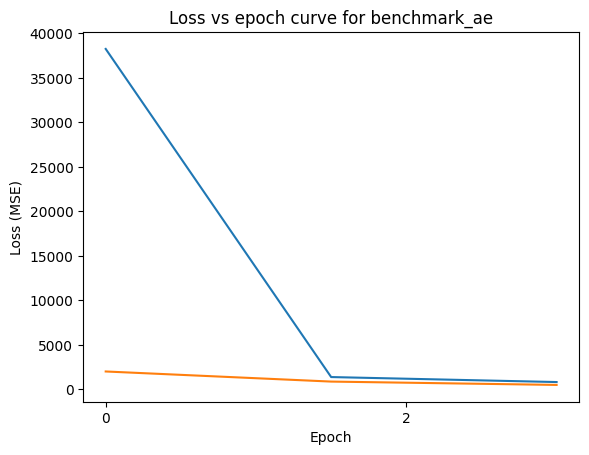

In [8]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title("Loss vs epoch curve for " + train_config["model_files"]["model_name"])
plt.xticks(np.arange(0,21,2))
plt.plot(np.linspace(0, train_config["hyperparameters"]["epochs"], train_config["hyperparameters"]["epochs"]), loss)
plt.plot(np.linspace(0, train_config["hyperparameters"]["epochs"], train_config["hyperparameters"]["epochs"]), val_loss)

plt.savefig(os.path.join(train_config["outputs"]["graph_directory"], datetime.datetime.now().strftime(
    train_config["outputs"]["date_time_format"]) + "_LossVsEpoch.png"), format="png", bbox_inches="tight")
plt.show()

**Model Evaluation**

---

Processing the signal data

In [9]:
#Opening file in read mode...
file_name = "Ato4l_lepFilter_13TeV"
signal_file = h5py.File(train_config["data_files"][file_name], 'r')



#Checking for validity...
is_file_valid = False
required_dataset = train_config["datasets"]["required_dataset"]
for key in signal_file['/']:
    if isinstance(signal_file['/' + key], h5py.Dataset) and key == required_dataset:
        is_file_valid = True



#Stop if file is not valid...
if not is_file_valid:
    raise Exception("File Does not contain the required dataset")



#Save it into a numpy array...
signal_data = np.array(signal_file[required_dataset])

for i, batch in enumerate(signal_data):
    pt_sum = 0
    for j, particle in enumerate(signal_data[i, :, :]):
        if particle[3] != 0:
            pt_sum += particle[0]
    for j, particle in enumerate(signal_data[i, :, :]):
        particle[0] = particle[0] / pt_sum
signal_data = signal_data[:, :,0:3].reshape(-1, 57)



reconstructed_background = model(data_test).numpy()
reconstructed_signal = model(signal_data).numpy()

background_scores = np.mean((reconstructed_background - data_test)**2,axis=1)
signal_scores = np.mean((reconstructed_signal - signal_data)**2, axis=1)

truth_values = np.concatenate([
    np.zeros(len(background_scores)),
    np.ones(len(signal_scores))
])
scores = np.concatenate([
    background_scores, 
    signal_scores
])

Generate AUC and loss histograms, seeing if we can get that anomaly score to work...

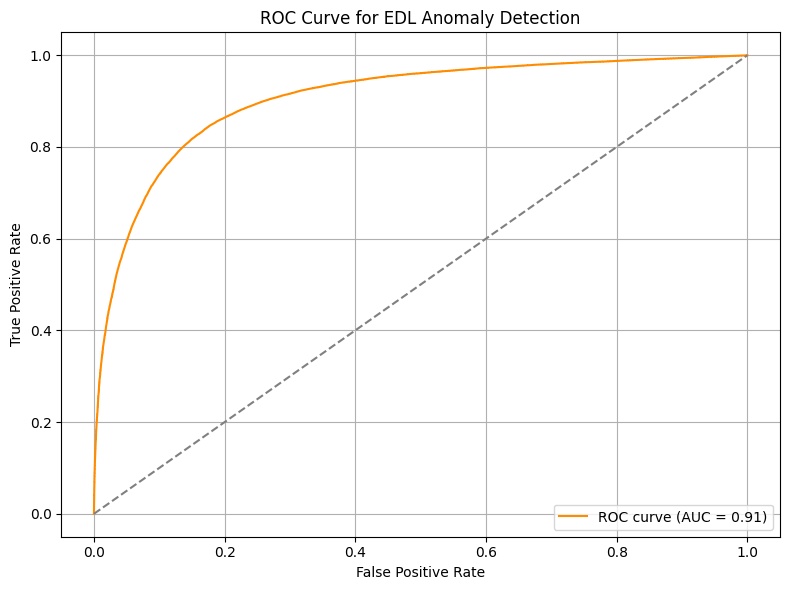

In [ ]:
fpr, tpr, _ = sk.roc_curve(truth_values, scores)
roc_auc = sk.auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(train_config["model_files"]["model_name"])
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
